# Hyper-Parameter Optimisaton with the Iris dataset

## Introduction:

This notebook will demonstrate how to explore a dataset and then build an artifical neural network that is able to predict an outcome based on a dataset. Then furthermore, will demonstrate how tweaking hyper-parameters changes how neural networks behave and explore the difference in accuracy and performance.
The dataset that will be used is the Iris dataset which is a very basic and is considered as a good beginner dataset for people new to machine learning.

There are mulitple ways of searching for good hyper-parameters and one way of doing so is by hand-tuning it. This is by trying out one set of parameters to see how they perform and then you manually change another set of parameters to see if they have improved the performance. This becomes more of an art rather than a science as you mainly use your intuition to see what works. However, it becomes very time-consuming and it's extremely unlikely you will find the most optimal parameters as they are usually counter-intuitive.

Another way of finding the best hyper parameters would be to find a valid range for each of the parameters and divide it into evenly spaced intervals and this is known as grid search but the problem with this is that even if you get a fairly coarse division of each parameter for example 10 but the number of possible combinations grows exponentially as you begin to add more parameters. This is known as the curse of dimensionality.

Additionally another way of finding good hyper-parameters is by random search, so unlike Grid Search all the values are randomly generated. As the amount of parameters increases for random search the chances of finding the optimal parameters becomes close to zero.

However, there is another method of finding optimal hyper-parameters and it is known as Bayesian Optimisation.

The Bayesian Optimisation method of finding hyper-parameters attempts to minimise the cost of hyper-parameter optimisation by creating a one kind of model known as a Gaussian Process. Using this it gives an estimate of how the performance may vary with changes to the hyper-parameters. So whenever the model is evaluated for a set of hyper-parameters it is clear based on the test sets what the performance with maybe a bit of variation from the noise. The bayesian optimiser is able to give a new suggestion for hyper-parameters in a region of a search space that has not been explored yet, or hyper-parameters that the Bayesian optimiser thinks will give the most improvement. Then it will repeat the process for as long as you want and then you are able to pick the best parameters.

The main algorithm for how Bayesian optimisation works is:

Start with some default hyper-parameters

Create a neural network using these hyper-parameters

Train the neural network

Evaluate the perfomance of the network

Perform a classification accuracy on the validation_set

Update the Gaussian model with the results

Then sample the model to maximise the expected improvement

Update the hyper-parameters and loop

## Goals:

1. Explore the dataset, pre process the data and see what we're working with.
2. Build an artificial neural network that is able to look at the features from a dataset and to classify what species an iris flower is.
3. To then investigate different hyper-parameter settings then log the findings to see how it changed the accuracy and performance.

### Import

In [2]:
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')

In [3]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import load_model

In [6]:
import skopt
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective

### Exploring the data

In [7]:
# seaborn already has the iris dataset inside the library
df = sns.load_dataset("iris") 
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [8]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [9]:
df.isnull().sum().max()

0

This means that there are no null values in the dataset which makes pre-processing the dataset a lot easier.

In [10]:
df['species'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

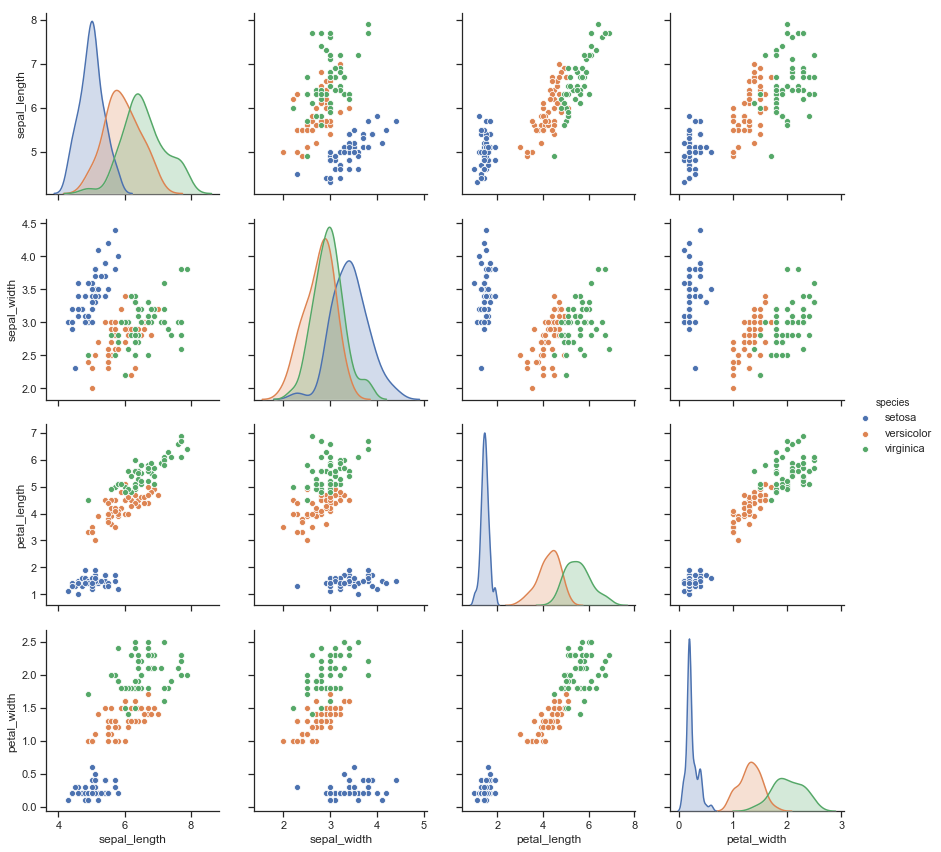

In [11]:
sns.set(style="ticks")
sns.pairplot(df.iloc[:,0:6], hue="species", size=3, diag_kind="kde")

In [12]:
num_classes = 3

### Hyper-Parameters

Here we have the search dimensioin for the learning rate with a lower bound and upper bound.

In [13]:
dim_learning_rate = Real(low=1e-6, high=5e-1, prior='log-uniform',name='learning_rate')

This is the search dimension for the number of dense layers in the neural network and it had a lower bound of 1 and upper bound of 5.
This is because you need atleast 1 layer and for a basic dataset you really don't need a big network.

In [14]:
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')

The search dimension for the amount of nodes that will be in the models.

In [15]:
dim_num_dense_nodes = Integer(low=4, high=512, name='num_dense_nodes')

Again this is the search dimension for the activation function and just keeping it simple as these should work.

In [16]:
dim_activation = Categorical(categories=['relu', 'sigmoid'],name='activation')

Putting the dimensions into a list so that it's easier to parse into the fitness function later.

In [17]:
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]

We need to make sure to pick parameters that are good but not that good

In [18]:
default_parameters = [4e-5, 1, 16, 'relu']

### Helper Functions

A helper function to help log the training progress for all the parameter combinations so that they can be viewed and compared in TensorBoard.

In [19]:
def log_dir_name(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):

    # The dir-name for the TensorBoard log-dir.
    s = "./logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate, num_dense_layers, num_dense_nodes, activation)

    return log_dir

Helper functions for predicting and testing to refrain from getting too messy.

In [20]:
def y_predict(model):
    return model.predict(X_test)

def y_test_class(y_test):
    return  np.argmax(y_test,axis=1)

def y_pred_class(y_pred):
    np.argmax(y_pred,axis=1)

## Building the model

So now X contains all flower measurement values, y contains all species categories.
We must convert these text values into a machine usable format. To do that we use the fit_transform function from sklearn label encoder library to encode the species values 0 through 2 then we'll then one-hot encode these values using panda's get dummies function so now we have X equal to all the flower measuremenet values and Y is the one-hot encoded values for the species.

In [21]:
# spltting the data into training and test
X = df.iloc[:,0:4].values
y = df.iloc[:,4].values
# iloc allows to read specific range of values from specific locations in the dataset

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y1 = encoder.fit_transform(y)
Y = pd.get_dummies(y1).values

from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

We create a variable for the validation data to see which choice of hyper-paramaters works best on unseen data.

In [22]:
validation_data = (X_test, y_test)

The main function called when creating a model for a neural network.

In [23]:
def create_model(learning_rate, num_dense_layers, num_dense_nodes, activation):
    
    model = Sequential()

    model.add(InputLayer(input_shape=(4,)))
    model.add(Flatten())
    
    for i in range(num_dense_layers):
        # name of the layer. 
        name = 'layer_dense_{0}'.format(i+1)
        
        # Adding the dense layer to the model which has two hyper-parameters that can be optimised.
        model.add(Dense(num_dense_nodes,activation=activation,name=name))
    # num of classes will always be 3 with the iris dataset
    model.add(Dense(num_classes, activation='softmax'))

    # since we're using a classifier with more than two classes we want to use categorical crossentropy loss function
    optimiser = Adam(lr=learning_rate)
    
    model.compile(optimizer=optimiser,loss='categorical_crossentropy',metrics=['accuracy']) 

    return model

Variable to store the best model

In [24]:
path_best_model = 'best_model.h5'

We have to set the best accuracy variable outside the fitness function

In [25]:
best_accuracy = 0.0

The fitness function is the main function that creates and trains a neural network with the given hyper-parameters and then is able to evaluates its performance. The function returns the accuracy which is a negative classifcation because skopt performs minimisation instead of maximisation.

The hyper-parameters are:

learning_rate:     Learning-rate for the optimizer.

num_dense_layers:  Number of dense layers.

num_dense_nodes:   Number of nodes in each dense layer.

activation:        Activation function for all layers.

In [26]:
# This is the style skopt uses for singles lists.
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,num_dense_nodes, activation):

    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate,num_dense_layers=num_dense_layers,num_dense_nodes=num_dense_nodes,activation=activation)
    
    # for the log files
    log_dir = log_dir_name(learning_rate, num_dense_layers,num_dense_nodes, activation)
    
    # Create a callback-function for Keras which will be run after each epoch has ended during training.
    callback_log = TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False)
    
    # using the fit function from keras to train the model
    history = model.fit(x=X_train, y=y_train,epochs=3,batch_size=128, validation_data=validation_data, callbacks=[callback_log])
    
    # get the classification accuracy on the validation-set after the last training-epoch.
    accuracy = history.history['val_acc'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside of this function.
    global best_accuracy
    # I use a global best model here because I found issues loading models in keras
    global best_model
 
    if accuracy > best_accuracy:
        # Save the new model
        model.save(path_best_model)
        best_model = model
        best_accuracy = accuracy

    del model
    
    # have to clear the keras session otherwise it will not add models to graphs correctly
    K.clear_session()
    
    # To find the minimisation we need to return a negative classification
    return -accuracy

### Test Run

In [27]:
fitness(x=default_parameters)

learning rate: 4.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Train on 120 samples, validate on 30 samples
Epoch 1/3
120/120 [==============================] - 0s 4ms/step - loss: 2.6087 - acc: 0.3250 - val_loss: 2.5395 - val_acc: 0.3667
Epoch 2/3
120/120 [==============================] - 0s 50us/step - loss: 2.6073 - acc: 0.3250 - val_loss: 2.5380 - val_acc: 0.3667
Epoch 3/3
120/120 [==============================] - 0s 50us/step - loss: 2.6056 - acc: 0.3250 - val_loss: 2.5364 - val_acc: 0.3667

Accuracy: 36.67%



-0.36666667461395264

In keras you train a model using the fit command

### Hyper-Parameter Optimisation

Now to finally run the model with hyper-parameter optimisation using Bayesian optimisaton from the scikit-optimize package.
This first calls the fitness function with the default parameters set earlier as a starting point to speed up the process.

There are also other parameters you can play around with like the number of calls. However, running it too many times becomes very costly quickly especially with big datasets you may have to train models for days.

Another thing to optimise are the amount of epochs for each model. Again overdoing it will begin to become costly as the the time to train models will increase.

There are also other alternatives to Bayesian optimisers that I could've tried like Random Forests.

In [40]:
search_result = gp_minimize(func=fitness,dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=40,
                            x0=default_parameters)

learning rate: 4.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Train on 120 samples, validate on 30 samples
Epoch 1/3
120/120 [==============================] - 0s 1ms/step - loss: 2.2568 - acc: 0.3083 - val_loss: 1.6427 - val_acc: 0.4333
Epoch 2/3
120/120 [==============================] - 0s 25us/step - loss: 2.2562 - acc: 0.3083 - val_loss: 1.6424 - val_acc: 0.4333
Epoch 3/3
120/120 [==============================] - 0s 42us/step - loss: 2.2555 - acc: 0.3083 - val_loss: 1.6421 - val_acc: 0.4333

Accuracy: 43.33%

learning rate: 1.3e-02
num_dense_layers: 3
num_dense_nodes: 107
activation: relu

Train on 120 samples, validate on 30 samples
Epoch 1/3
120/120 [==============================] - 0s 1ms/step - loss: 1.0689 - acc: 0.3250 - val_loss: 1.6084 - val_acc: 0.2000
Epoch 2/3
120/120 [==============================] - 0s 33us/step - loss: 1.2831 - acc: 0.3667 - val_loss: 0.6932 - val_acc: 0.8000
Epoch 3/3
120/120 [==============================] - 0s 29us/step - lo

Train on 120 samples, validate on 30 samples
Epoch 1/3
120/120 [==============================] - 0s 2ms/step - loss: 1.1054 - acc: 0.3083 - val_loss: 1.1040 - val_acc: 0.4333
Epoch 2/3
120/120 [==============================] - 0s 42us/step - loss: 1.1042 - acc: 0.3083 - val_loss: 1.1055 - val_acc: 0.4333
Epoch 3/3
120/120 [==============================] - 0s 33us/step - loss: 1.1030 - acc: 0.3083 - val_loss: 1.1071 - val_acc: 0.4333

Accuracy: 43.33%

learning rate: 1.9e-05
num_dense_layers: 5
num_dense_nodes: 512
activation: sigmoid

Train on 120 samples, validate on 30 samples
Epoch 1/3
120/120 [==============================] - 0s 2ms/step - loss: 1.3094 - acc: 0.3083 - val_loss: 1.0951 - val_acc: 0.4333
Epoch 2/3
120/120 [==============================] - 0s 33us/step - loss: 1.2974 - acc: 0.3083 - val_loss: 1.0889 - val_acc: 0.4333
Epoch 3/3
120/120 [==============================] - 0s 33us/step - loss: 1.2840 - acc: 0.3083 - val_loss: 1.0828 - val_acc: 0.4333

Accuracy: 43.33

Epoch 2/3
120/120 [==============================] - 0s 33us/step - loss: 1.6802 - acc: 0.3250 - val_loss: 1.0597 - val_acc: 0.4333
Epoch 3/3
120/120 [==============================] - 0s 33us/step - loss: 1.2348 - acc: 0.3083 - val_loss: 1.2606 - val_acc: 0.2000

Accuracy: 20.00%

learning rate: 7.5e-04
num_dense_layers: 5
num_dense_nodes: 175
activation: relu

Train on 120 samples, validate on 30 samples
Epoch 1/3
120/120 [==============================] - 0s 2ms/step - loss: 1.1389 - acc: 0.3083 - val_loss: 1.0756 - val_acc: 0.2000
Epoch 2/3
120/120 [==============================] - 0s 33us/step - loss: 1.0508 - acc: 0.3667 - val_loss: 1.0689 - val_acc: 0.2000
Epoch 3/3
120/120 [==============================] - 0s 42us/step - loss: 0.9979 - acc: 0.3667 - val_loss: 1.0494 - val_acc: 0.2333

Accuracy: 23.33%

learning rate: 5.8e-03
num_dense_layers: 4
num_dense_nodes: 17
activation: relu

Train on 120 samples, validate on 30 samples
Epoch 1/3
120/120 [==============================]

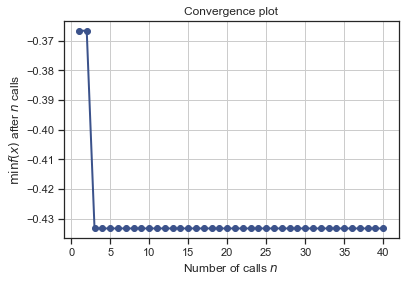

In [29]:
plot_convergence(search_result)

This shows the best hyper-parameters found by the Bayesian optimiser

In [30]:
search_result.x

[1.9199332734788812e-05, 1, 325, 'relu']

In [31]:
space = search_result.space

This shows the fitness.

In [41]:
search_result.fun

-0.800000011920929

Here this shows all the hyper-parameters that the Bayesian optimiser tried and the fitness values associated.

In [34]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-0.4333333373069763, [6.4125805837816104e-06, 3, 152, 'sigmoid']),
 (-0.4333333373069763, [8.279434940844027e-06, 3, 493, 'sigmoid']),
 (-0.4333333373069763, [1.4630685746221431e-05, 3, 479, 'sigmoid']),
 (-0.4333333373069763, [1.9199332734788812e-05, 1, 325, 'relu']),
 (-0.4333333373069763, [0.0001523935561110325, 4, 24, 'sigmoid']),
 (-0.4333333373069763, [0.020510634365498173, 3, 31, 'sigmoid']),
 (-0.4333333373069763, [0.02367114794698, 3, 33, 'sigmoid']),
 (-0.4333333373069763, [0.11618709143341169, 3, 159, 'sigmoid']),
 (-0.4333333373069763, [0.4228568077575526, 3, 469, 'sigmoid']),
 (-0.36666667461395264, [1e-06, 3, 310, 'relu']),
 (-0.36666667461395264, [1.201614682077176e-06, 3, 451, 'sigmoid']),
 (-0.36666667461395264, [3.7261807340081385e-06, 1, 347, 'relu']),
 (-0.36666667461395264, [4.980720475620101e-06, 3, 182, 'sigmoid']),
 (-0.36666667461395264, [6.514815917748987e-06, 2, 429, 'sigmoid']),
 (-0.36666667461395264, [8.322373978088568e-06, 3, 485, 'sigmoid']),
 (-0.3666

## Evaluation

Running more iterations of the Bayesian optimiser will greatly increase your chances of getting a model however can be very taxing. After going through tests I only once got a model that had 100% accuracy. I would probably only recommend increasing the amount of iterations if you really need high accuracy or have really good processing power.

Hand tuning the amount of epochs increased the accuracy of existing models however became extremely costly when I tested it on other datasets specifically datasets with images. This is because iris dataset is really fast and quick to train with very few samples.

## Conclusion

To conclude, on how to optimise neural networks with hyper-parameters. I found that using a Bayesian optimisation was an interesting yet effective way on improving hyper-parameters without having to do tune the parameters yourself. Compared to hand tuning this is by far a much more superiror way of finding hyper-parameters because it is nowhere near as time consuming and not relying on intuition. Also compared to a Grid search or Random Search it is by far less time consuming and will most likely find superior hyper-parameters.